# Raster Data (`rioxarray`)

> This page is a Jupyter Notebook that can be [found and downloaded at the GitHub repository](https://github.com/trchudley/geospatial-python-durham/blob/main/website/02_using/03c_raster_data.ipynb).

## Introducing `rioxarray`

There's a reason I kept the raster data (arguably a simpler problem than n-d climate data) until after I introduced xarray. Raster data in python has arguably been quite late to mature. There are [formal GDAL/OSGO bindings](https://gdal.org/en/stable/tutorials/raster_api_tut.html), but these are very low-level and present way too much information up front to be useful for large-scale data analysis. Later, a [pacakge called `rasterio` came along](https://rasterio.readthedocs.io/en/latest/index.html), which aimed to wrap GDAL functionality in a much nicer Pythonic style. But this was still slightly unintuitive, and didn't play nicely with the rest of the Python geospatial/climate data ecosystem.

In the past few years, much of the community has been consolidating around a [package called `rioxarray`](https://corteva.github.io/rioxarray/html/rioxarray.html), which is my preferred and recommended option. It wraps all of the prior GDAL and `rasterio` functionality into an _extension_ for xarray, which is accessible through the `.rio` accessor (more on this below). As a result, you now don't need to know different libraries to manage e.g. `.nc` and `tif` files. This is in much the same way that geopandas is an extension of pandas, and means you can tackle `.csv` and `.shp` files from the same angle as well!

In [ ]:
import rioxarray as rxr
import matplotlib.pyplot as plt

As with previous examples, you can force-feed rioxarray any standard file type and it should accept it. 

For now, let's load an online GeoTiff (I will show you more advanced moves, such as how to search for satellite data and get ice velocity and DEMs, in the next section of the documentation).

In [17]:

# Set the location of the relevant ITS_LIVE RGB mosaic tile
tif_fpath = 'https://its-live-data.s3-us-west-2.amazonaws.com/rgb_mosaics/GRE2/Greenland_median_S2_Aug_2019_0m3_m22.tif'

# Provide the bounds of Store Glacier (so we don't download the entire tile)
store_glacier_bounds = -211000,-2138000,-204000,-2128000

# Load the xarray dataset using rioxarray
rxds = rxr.open_rasterio(tif_fpath).rio.clip_box(*store_glacier_bounds)

Note that, because we're downloading a large tile from an online source, I have provided some glacier bounds and fed them in using the new `rioxarray`-specific function `.rio.clip_box()`. This is what we mean by the `.rio` _accessor_: the `.rio` tag opens up whole new functionalities. 

Out of interest, xarray by default performs _lazy_ evaluation, which means it doesn't begin to process anything until you give it a task where it has to display a result. This is why, even though `.clip_box` comes after `open_rasterio` in the order of operations, we still only download the subset. At the point at which we force xarray to evaluate (when displaying the figure, below), xarray works backwards and only calculates/downloads exactly what it needs to to fulfil our request. Efficient!

Anyway, let's see what we've got:

In [18]:
rxds

<xarray.DataArray (band: 3, y: 1000, x: 700)> Size: 2MB
[2100000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 6kB -2.11e+05 -2.11e+05 ... -2.04e+05 -2.04e+05
  * y            (y) float64 8kB -2.128e+06 -2.128e+06 ... -2.138e+06 -2.138e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('vis-red', 'vis-green', 'vis-blue')

There's a couple things to note here. The first is the `spatial_ref` coordinate. This is the rioxarray-specific data that keeps a record of the spatial metadata of our raster data, much like how Geopandas did for a pandas dataframe. This means we can indeed check our CRS:

In [19]:
rxds.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / NSIDC Sea Ice Polar Stereographic North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",70],PARAMETER["central_meridian",-45],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH],AUTHORITY["EPSG","3413"]]')

In [20]:
rxds.rio.bounds()

(-211000.0, -2138000.0, -204000.0, -2128000.0)

(Note how this time we access this information via the `.rio` accessor).

The second is that, rather than time, our coordinates are `band`. Depending on how you load the data, sometimes this could be useful strings (e.g. `"band_01"`, or `"near_infra_red"`). However, often this is lost on loading and you just get, as in this case, integer labels (`[1, 2, 3]`). You will have to consult the documentation to find out what each band means. Sometimes we can infer: if you've loaded Sentinel-2 data and there are 13 bands, you might hope they're in standard band order. If you've got three bands, you might hope they're red-green-blue! As we've got three, a good way to test is by using the xarray-standard `.plot.imshow()`. If it receives a dataset with three bands, it assumed these are R-G-B. 

Let's test:

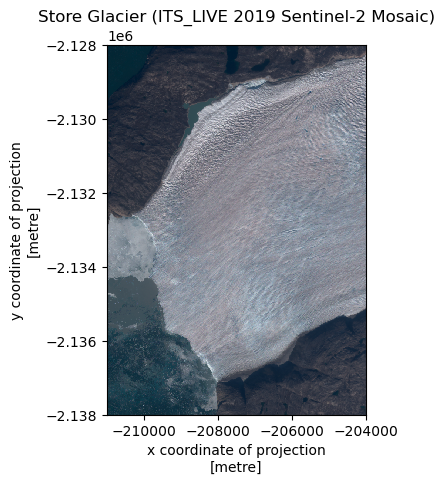

In [21]:
fig, ax = plt.subplots()
rxds.plot.imshow(ax=ax)
ax.set_aspect('equal')
ax.set_title('Store Glacier (ITS_LIVE 2019 Sentinel-2 Mosaic)')
plt.show()

## Manipulating Raster Datasets

One final thing to show what you might try and do at this point is do some simple band maths. We have RGB data, so why don't we try and calculate $NDWI_{ice}$, defined as

$$
    NDWI_{ice} = \frac{Blue - Red}{Blue + Red}.
$$

With red being band 1 and blue being band 2, we can calculate as follows:

In [22]:

# Bands are currently scaled 0-255, so we divide by 255 to normalise 0-1 before
# using them in the equation
ndwi = (
    ( rxds.sel(band=3)/255 - rxds.sel(band=1)/255 ) / 
    ( rxds.sel(band=3)/255 + rxds.sel(band=1)/255 )
    )

Now let's test by plotting:

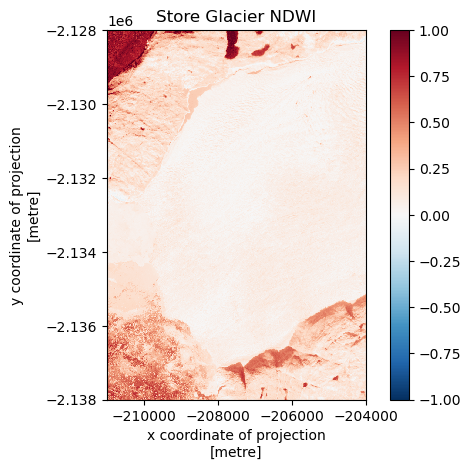

In [23]:
fig, ax = plt.subplots()
ndwi.plot.imshow(ax=ax, add_colorbar=True)
# rxds.isel(band=2).plot.imshow(ax=ax, add_colorbar=True)
ax.set_aspect('equal')
ax.set_title('Store Glacier NDWI')
plt.show()

Great! Note the sneaky addition of `add_colorbar=True` to get a colorbar up and running. If xarray senses your dataset goes above and below 0, it will try and force a red-blue divergent colour scale automatically. I will leave you to explore how to pick colour scales and min/max bounds.

Why not try and 'threshold' the data to identify regions of likely water?

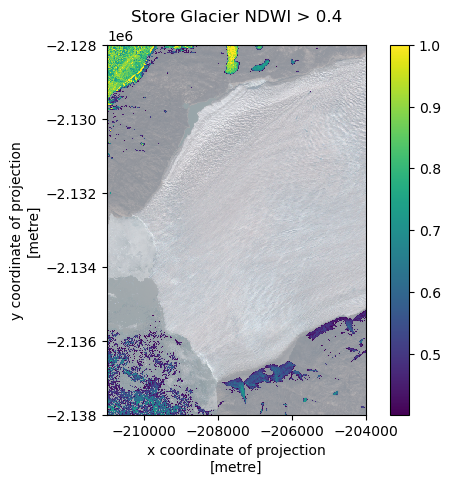

In [24]:
threshold = 0.4

# Mask where NDWI is less than threshold, replace with nan
ndwi_thres = ndwi.where(ndwi > threshold, np.nan)

# ndwi_thresh = ndwi > threshold
# ndwi_thres = ndwi > threshold

fig, ax = plt.subplots()
rxds.plot.imshow(ax=ax, alpha=0.5)
ndwi_thres.plot.imshow(ax=ax)
ax.set_aspect('equal')
ax.set_title(f'Store Glacier NDWI > {threshold}')
plt.show()


Looks like a reasonable result. I'm not surprised the thresholding is sketchy - we're doing this from an annual mosaic rather than a single image. It's just an example to see what you can do, and it seems to be working.